In [29]:
import os, zipfile
import tensorflow as tf
import pandas as pd
import demoji
import csv
import re
import string
import pickle

In [2]:
# extracting files
zip_path = 'archive.zip'
extract_dir = './datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_dir)


ds_path = './datasets/'

In [3]:
#check data
df_train = pd.read_csv(ds_path+'twitter_training.csv', names=['ID','user','SC','Comment'])
df_test = pd.read_csv(ds_path+'twitter_validation.csv', names=['ID','user','SC','Comment'])

In [4]:
def dropRowValue(dataframe,column,values):
    return dataframe[~dataframe[column].isin(values)]

# categorizing in positive and negative, and dropping unnecessary columns
filter_df_train = dropRowValue(df_train,'SC',['Neutral','Irrelevant']).drop(['ID','user'], axis=1)
filter_df_test = dropRowValue(df_train,'SC',['Neutral','Irrelevant']).drop(['ID','user'], axis=1)

In [5]:
x_train = filter_df_train['Comment'].to_list()
y_train = filter_df_train['SC'].to_list()
x_test = filter_df_train['Comment'].to_list()
y_test = filter_df_train['SC'].to_list()

In [6]:
y_train_num = []
y_test_num = []
for row_train, row_test in zip(y_train,y_test):
    if row_train == 'Positive' or row_test == 'Positive':
        y_train_num.append(1)
        y_test_num.append(1)
    else:
        y_train_num.append(0)
        y_test_num.append(0)

In [7]:
# generating the emoji mask
import emoji

def emojiMask(sentence):
    sentenceEmojiMask = emoji.replace_emoji(sentence,
                        replace=lambda chars,
                        data_dict: chars.encode('ascii', 'namereplace').decode())
    return sentenceEmojiMask


x_train_emojimask = [emojiMask(str(row)) for row in x_train]
x_test_emojimask = [emojiMask(str(row)) for row in x_test]

## Second approach

In [88]:
# tensor vector for model
def trainTensorSlice(xtrain,ytrain):
    x_tensor = tf.constant(xtrain)
    y_tensor = tf.constant(ytrain)
    dataset_tensor = tf.data.Dataset.from_tensor_slices((x_tensor,y_tensor)) # no batching, the batching will be later on
    return dataset_tensor

train_ds = trainTensorSlice(x_train_emojimask,y_train_num)
test_ds = trainTensorSlice(x_test_emojimask,y_test_num)

In [90]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [93]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2024-04-24 13:57:56.100665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [43374]
	 [[{{node Placeholder/_0}}]]
2024-04-24 13:57:56.101239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]


In [96]:
import numpy as np

vocab = np.array(encoder.get_vocabulary())
vocab.shape

(1000,)

### start example

Generate a vocabulary out of the training dataset and de-gerenate it

In [99]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'It\'s a shame that Overwatch doesn\'t do any OWL-related events in the game, for example, in "arcade mode," where you compete with fans of other teams for points, and the team skins are always on'
 b'the ohhh you'
 b'Continuing my endeavors of bringing the immense bullshit the UNFINISHED games has. This game has no fuckimg integrity on making it a one one release a million thing despite ALL the money the get from from company from VC alone. An embarrassment. @NBA2K @Ronnie2K @2K https://t.co/NpyLtg9WHb]'
 b'Instead of promoting fix-ur servers'
 b'My 4 fave games are Minecraft. Borderlands 2.Forza horizon 4. Lego star wars'
 b'Hmmm or'
 b'It was one of the coolest events in the game so far. Not only was it like an open space to interact with, but actually playing the game and running around the map and "solving the mystery" was so much fun.'
 b'a one.'
 b'2009 Having fun playing some pretty overwatch... store. for playstation. com /'
 b'Interesting'
 b"Was it really four years

2024-04-24 14:02:28.664341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]
2024-04-24 14:02:28.665275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]


In [100]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 31,   6,   1,  16, 168, 281,  43, 171,   1,   1,  12,   2,  17,
         11,   1,  12,   1, 398, 253,  14,   1,  18, 627,   8, 231, 818,
         11, 591,   5,   2, 214, 847,  25, 186,  15,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   1,  14,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  13,   1,   8,   1,   2,   1, 582,   2,   1,  69,  62,   9,
         17,  62,  47,   1,   1,  15, 307,  10,   6,  48,  48, 366,   6,
        558, 233, 681,  27,   2, 219,   2,  32,  36,  36, 293,  36,   1,
        816,  57,   1, 125, 523, 330,   1,   0,  

In [101]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'It\'s a shame that Overwatch doesn\'t do any OWL-related events in the game, for example, in "arcade mode," where you compete with fans of other teams for points, and the team skins are always on'
Round-trip:  its a [UNK] that overwatch doesnt do any [UNK] [UNK] in the game for [UNK] in [UNK] mode where you [UNK] with fans of other teams for points and the team skins are always on                              

Original:  b'the ohhh you'
Round-trip:  the [UNK] you                                                              

Original:  b'Continuing my endeavors of bringing the immense bullshit the UNFINISHED games has. This game has no fuckimg integrity on making it a one one release a million thing despite ALL the money the get from from company from VC alone. An embarrassment. @NBA2K @Ronnie2K @2K https://t.co/NpyLtg9WHb]'
Round-trip:  [UNK] my [UNK] of [UNK] the [UNK] bullshit the [UNK] games has this game has no [UNK] [UNK] on making it a one one release a million thi

### End example

In [128]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [129]:
# Sigmoid activation function, which converts logits (raw model outputs) to probabilities
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [131]:
history = model.fit(train_dataset, 
                    epochs=10,
                    verbose=2)

Epoch 1/10


2024-04-24 14:51:50.631101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-04-24 14:51:53.683877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


678/678 - 39s - loss: 0.5650 - accuracy: 0.7089 - 39s/epoch - 58ms/step
Epoch 2/10
678/678 - 32s - loss: 0.4133 - accuracy: 0.8142 - 32s/epoch - 47ms/step
Epoch 3/10
678/678 - 32s - loss: 0.3879 - accuracy: 0.8231 - 32s/epoch - 48ms/step
Epoch 4/10
678/678 - 32s - loss: 0.3744 - accuracy: 0.8293 - 32s/epoch - 47ms/step
Epoch 5/10
678/678 - 32s - loss: 0.3634 - accuracy: 0.8342 - 32s/epoch - 46ms/step
Epoch 6/10
678/678 - 32s - loss: 0.3512 - accuracy: 0.8389 - 32s/epoch - 47ms/step
Epoch 7/10
678/678 - 34s - loss: 0.3390 - accuracy: 0.8445 - 34s/epoch - 50ms/step
Epoch 8/10
678/678 - 30s - loss: 0.3285 - accuracy: 0.8508 - 30s/epoch - 45ms/step
Epoch 9/10
678/678 - 31s - loss: 0.3186 - accuracy: 0.8558 - 31s/epoch - 45ms/step
Epoch 10/10
678/678 - 31s - loss: 0.3092 - accuracy: 0.8603 - 31s/epoch - 45ms/step


In [132]:
loss, accuracy = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

678/678 [==============================] - 13s 15ms/step - loss: 0.2951 - accuracy: 0.8678
Loss: 0.2950778007507324
Accuracy: 0.8678470849990845


dict_keys(['loss', 'accuracy'])


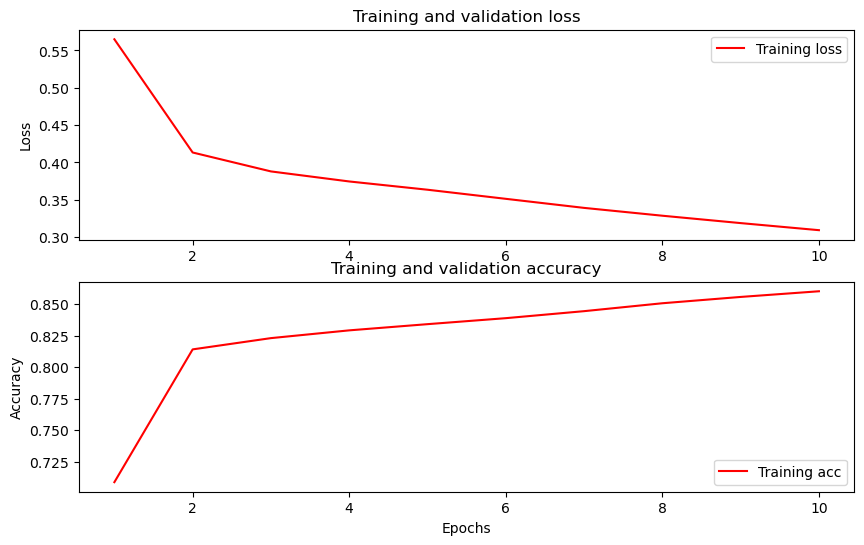

In [139]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
# val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [142]:
examples = [
    "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D", 
    "is upset that he can't update his Facebook by ...",
    '@Kenichan I dived many times for the ball. Man...',
    'my whole body feels itchy and like its on fire',
    "@nationwideclass no, it's not behaving at all...."
]

model(tf.constant(examples))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.90124977],
       [0.01111175],
       [0.9271256 ],
       [0.80073273],
       [0.10089594]], dtype=float32)>

In [ ]:
def emojiMask(sentence):
    sentenceEmojiMask = emoji.replace_emoji(sentence,
                        replace=lambda chars,
                        data_dict: chars.encode('ascii', 'namereplace').decode())
    return sentenceEmojiMask


example_filtered = [emojiMask(str(row)) for row in x_train]

## First approach

In [8]:
import tensorflow_text as tf_text

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(x_train_emojimask)
test_tokens = tokenizer.tokenize(x_test_emojimask)

2024-04-23 22:41:55.270601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-23 22:41:55.270674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: HP-Pavilion
2024-04-23 22:41:55.270687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: HP-Pavilion
2024-04-23 22:41:55.270839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.54.15
2024-04-23 22:41:55.270881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.54.15
2024-04-23 22:41:55.270893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.54.15


In [9]:
from itertools import chain

def flattenChain(element):
    return list(chain.from_iterable(element))


flatten_train_tokens = list(set(flattenChain(train_tokens.to_list())))
flatten_test_tokens = list(set(flattenChain(test_tokens.to_list())))

In [10]:
def _CreateTable(vocab, num_oov=1):
    init = tf.lookup.KeyValueTensorInitializer(
        vocab,
        tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64),
        key_dtype=tf.string,
        value_dtype=tf.int64)
    return tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)

In [11]:
train_vocab = _CreateTable(flatten_train_tokens)
test_vocab = _CreateTable(flatten_test_tokens)

In [65]:
# tensor vector for model
def trainTensorSlice(xtrain,ytrain):
    x_tensor = tf.constant(xtrain)
    y_tensor = tf.constant(ytrain)
    dataset_tensor = tf.data.Dataset.from_tensor_slices((x_tensor,y_tensor)).batch(2)
    return dataset_tensor

train_ds = trainTensorSlice(x_train_emojimask,y_train_num)
test_ds = trainTensorSlice(x_test_emojimask,y_test_num)

In [66]:
def trainPreprocess(data, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    data = tokenizer.tokenize(data)
    data = data.merge_dims(-2,-1)
    ids = tf.ragged.map_flat_values(train_vocab.lookup, data)
    return (ids, labels)

def testPreprocess(data, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    data = tokenizer.tokenize(data)
    data = data.merge_dims(-2,-1)
    ids = tf.ragged.map_flat_values(test_vocab.lookup, data)
    return (ids, labels)

In [67]:
train_ds = train_ds.map(trainPreprocess)
test_ds = test_ds.map(testPreprocess)

In [68]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [63]:
reviews_data_array = ['I really liked this movie', 'not my favorite']
reviews_labels_array = [1,0]

train_x = tf.constant(reviews_data_array)
train_y = tf.constant(reviews_labels_array)

a = _CreateTable(['I', 'really', 'liked', 'this', 'movie', 'not', 'my', 'favorite'])

def preprocess(data, labels):
  t = tf_text.WhitespaceTokenizer()
  data = t.tokenize(data)
  # data = data.merge_dims(-2,-1)
  ids = tf.ragged.map_flat_values(a.lookup, data)
  return (ids, labels)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(2)
train_dataset = train_dataset.map(preprocess)

In [64]:
for e in train_dataset.take(1):
    print(e)

(<tf.RaggedTensor [[0, 1, 2, 3, 4], [5, 6, 7]]>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>)


2024-04-24 13:29:34.742706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype resource
	 [[{{node Placeholder/_6}}]]


In [38]:
def filter_dataset(tensor, nsplit=0, category_pos=0):
    split_tensor = tf.strings.split(tensor, ',', maxsplit=nsplit)
    sentiment_category = split_tensor[category_pos]

    return (True if sentiment_category != 'Irrelevant' else False)

In [39]:
# converting the data into tensor data using the filter
train_ds = tf.data.TextLineDataset('processed_twitter_train.csv').filter(selector_dataset)
test_ds = tf.data.TextLineDataset('processed_twitter_test.csv').filter(selector_dataset)

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [40]:
for e in train_ds.take(2):
    print(e)

tf.Tensor(b'2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"', shape=(), dtype=string)
tf.Tensor(b'2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"', shape=(), dtype=string)


2024-04-23 11:27:55.243632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [57]:
import json

# import the json file
with open('emoji-unicode.json') as json_file:
    emoji_dict= json.load(json_file)

# remove the unnecessary keys and values from the dictionary 
trash_keys = ['no',
              'emoji',
              'flagged',
              'keywords']

for trash_key in trash_keys:
    for _ in range(len(emoji_dict['emojis'])):
        emoji_dict['emojis'][_].pop(trash_key,None)

In [62]:
# processing the format to unicode
def format_to_unicode(s):
    code_point = int(s[2:], 16)
    return chr(code_point)

list_emoji_dict = emoji_dict['emojis']
len_list_emoji_dict = len(list_emoji_dict)
for _ in range(len_list_emoji_dict):
    for code, description in list_emoji_dict[_].items():
        emoji_uni = list_emoji_dict[_]['code']
        emoji_desc = list_emoji_dict[_]['description']
        df_train_ds['Comment'] = df_train_ds['Comment'].str.replace(format_to_unicode(emoji_uni), emoji_desc)
        df_test_ds['Comment'] = df_test_ds['Comment'].str.replace(format_to_unicode(emoji_uni), emoji_desc)

Once the dataset emoji mask is set, we can export the csv for including it into the general model. Indeed, if we want to, we can do the preprocessing job first including removing stoping words punctuation that might improve the performance in our model in this case.

In [63]:
#exporting the processed dataset into a csv file
df_train_ds.to_csv('processed_twitter_train.csv', index=False, header=False) 
df_test_ds.to_csv('processed_twitter_test.csv', index=False, header=False) 

In [68]:
for e in train_ds.skip(1).take(2):
    print(e)

tf.Tensor(b'2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"', shape=(), dtype=string)
tf.Tensor(b'2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"', shape=(), dtype=string)


2024-04-23 03:10:38.715556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [69]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [76]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [80]:
# build vocabulary and save it to vocabulary.obj
vocabulary = vectorize_layer.adapt(train_ds)
vocab_file = open('vocabulary.obj','wb')
pickle.dump(vocabulary,vocab_file)

In [ ]:
# # for loading the vocabulary
# vocab_file = open('vocabulary.obj','rb')
# vocabulary = pickle.load(vocab_file)


In [81]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label